In [1]:
import os
import tensorflow as tf
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
from tensorflow import keras
import pickle
import numpy as np
from  keras.optimizers import Adam
#from keras.optimizers import Adam
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
#tf.debugging.set_log_device_placement(True)
import matplotlib.pyplot as plt
from keras.layers import Dropout, Flatten, Dense, GlobalAveragePooling2D

Using TensorFlow backend.


Num GPUs Available:  1


In [35]:
# Get a ResNet50 model
def resnet50_model(classes=3, *args, **kwargs):
    # Load a model if we have saved one
    cwd = os.getcwd()
    if(os.path.isfile(os.path.join(cwd,'resnet50_weights_tf_dim_ordering_tf_kernels.h5')) == True):
        return keras.models.load_model(os.path.join(cwd,'resnet50_weights_tf_dim_ordering_tf_kernels.h5'))
    # Create an input layer 
    input = keras.layers.Input(shape=(None, None, 3))
    # Create output layers
    output = keras.layers.ZeroPadding2D(padding=3, name='padding_conv1')(input)
    output = keras.layers.Conv2D(64, (7, 7), strides=(2, 2), use_bias=False, name='conv1')(output)
    output = keras.layers.BatchNormalization(axis=3, epsilon=1e-5, name='bn_conv1')(output)
    output = keras.layers.Activation('relu', name='conv1_relu')(output)
    output = keras.layers.MaxPooling2D((3, 3), strides=(2, 2), padding='same', name='pool1')(output)
    output = conv_block(output, 3, [64, 64, 256], stage=2, block='a', strides=(1, 1))
    output = identity_block(output, 3, [64, 64, 256], stage=2, block='b')
    output = identity_block(output, 3, [64, 64, 256], stage=2, block='c')
    output = conv_block(output, 3, [128, 128, 512], stage=3, block='a')
    output = identity_block(output, 3, [128, 128, 512], stage=3, block='b')
    output = identity_block(output, 3, [128, 128, 512], stage=3, block='c')
    output = identity_block(output, 3, [128, 128, 512], stage=3, block='d')
    output = conv_block(output, 3, [256, 256, 1024], stage=4, block='a')
    output = identity_block(output, 3, [256, 256, 1024], stage=4, block='b')
    output = identity_block(output, 3, [256, 256, 1024], stage=4, block='c')
    output = identity_block(output, 3, [256, 256, 1024], stage=4, block='d')
    output = identity_block(output, 3, [256, 256, 1024], stage=4, block='e')
    output = identity_block(output, 3, [256, 256, 1024], stage=4, block='f')
    output = conv_block(output, 3, [512, 512, 2048], stage=5, block='a')
    output = identity_block(output, 3, [512, 512, 2048], stage=5, block='b')
    output = identity_block(output, 3, [512, 512, 2048], stage=5, block='c')
    output = keras.layers.GlobalAveragePooling2D(name='pool5')(output)
    output = keras.layers.Dense(classes, activation='softmax', name='fc1000')(output)
    # Create a model from input layer and output layers
    model = keras.models.Model(inputs=input, outputs=output, *args, **kwargs)
    # Print model
    #print()
    #print(model.summary(), '\n')
    # Compile the model
    model.compile(loss='categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(lr=0.0001, clipnorm=0.001), metrics=['accuracy'])
    # Return a model
    return model


In [13]:
# Create an identity block
def identity_block(input, kernel_size, filters, stage, block):
    
    # Variables
    filters1, filters2, filters3 = filters
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'
    # Create layers
    output = keras.layers.Conv2D(filters1, (1, 1), kernel_initializer='he_normal', name=conv_name_base + '2a')(input)
    output = keras.layers.BatchNormalization(axis=3, name=bn_name_base + '2a')(output)
    output = keras.layers.Activation('relu')(output)
    output = keras.layers.Conv2D(filters2, kernel_size, padding='same', kernel_initializer='he_normal', name=conv_name_base + '2b')(output)
    output = keras.layers.BatchNormalization(axis=3, name=bn_name_base + '2b')(output)
    output = keras.layers.Activation('relu')(output)
    output = keras.layers.Conv2D(filters3, (1, 1), kernel_initializer='he_normal', name=conv_name_base + '2c')(output)
    output = keras.layers.BatchNormalization(axis=3, name=bn_name_base + '2c')(output)
    output = keras.layers.add([output, input])
    output = keras.layers.Activation('relu')(output)
    # Return a block
    return output

In [80]:
# Create a convolution block
def conv_block(input, kernel_size, filters, stage, block, strides=(2, 2)):
    # Variables
    filters1, filters2, filters3 = filters
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'
    # Create block layers
    output = keras.layers.Conv2D(filters1, (1, 1), strides=strides, kernel_initializer='he_normal', name=conv_name_base + '2a')(input)
    output = keras.layers.BatchNormalization(axis=3, name=bn_name_base + '2a')(output)
    output = keras.layers.Activation('relu')(output)
    output = keras.layers.Conv2D(filters2, kernel_size, padding='same', kernel_initializer='he_normal', name=conv_name_base + '2b')(output)
    output = keras.layers.BatchNormalization(axis=3, name=bn_name_base + '2b')(output)
    output = keras.layers.Activation('relu')(output)
    output = keras.layers.Conv2D(filters3, (1, 1), kernel_initializer='he_normal', name=conv_name_base + '2c')(output)
    output = keras.layers.BatchNormalization(axis=3, name=bn_name_base + '2c')(output)
    shortcut = keras.layers.Conv2D(filters3, (1, 1), strides=strides, kernel_initializer='he_normal', name=conv_name_base + '1')(input)
    shortcut = keras.layers.BatchNormalization(axis=3, name=bn_name_base + '1')(shortcut)
    output = keras.layers.add([output, shortcut])
    output = keras.layers.Activation('relu')(output)
    # Return a block
    return output

In [2]:
# Create a data generator for training
train_datagen = keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255, 
    shear_range=0.2,
    rotation_range=10,
    horizontal_flip=True,
    vertical_flip=True,
    validation_split=0.2)

# Create a train generator
train_generator = train_datagen.flow_from_directory( 
    '/scratch/e.conway/3DReconstruction/CNN_Buildings/Datasets/Dataset 2/', 
    target_size=(77, 77), 
    batch_size=32,
    color_mode='rgb',
    shuffle=True,
    class_mode='categorical',
    subset='training')

# Create a train generator
validation_generator = train_datagen.flow_from_directory( 
    '/scratch/e.conway/3DReconstruction/CNN_Buildings/Datasets/Dataset 2/', 
    target_size=(77, 77), 
    batch_size=32,
    color_mode='rgb',
    shuffle=True,
    class_mode='categorical',
    subset='validation')

print(train_generator)
print(validation_generator)

Found 11520 images belonging to 3 classes.
Found 2880 images belonging to 3 classes.


In [36]:
# Train a model
def train(start_index,name):
    # Variables, 25 epochs so far
    epochs = 10
    batch_size = 32
    train_samples = 3 * 5000 # 3 categories with 5000 images in each category
    validation_samples = 3 * 1000 # 10 categories with 1000 images in each category
    img_width, img_height = 259,259#32, 32
    # Get the model (10 categories)
    if(start_index == 'scratch'):
        model = resnet50_model(3)
    
    ########## RUN MODEL  ##########
    
    if(start_index == 'scratch'):
        # Start training, fit the model
        model.fit( 
            train_generator, 
            steps_per_epoch=train_generator.samples // batch_size, 
            validation_data=validation_generator, 
            validation_steps=validation_generator.samples // batch_size,
            epochs=epochs)
    elif(start_index == 'reconstructed'):
        # loading model
        model = keras.models.load_model(name)
        model.fit( 
            train_generator, 
            steps_per_epoch=train_generator.samples // batch_size, 
            validation_data=validation_generator, 
            validation_steps=validation_generator.samples // batch_size,
            epochs=epochs)
    # Save model to disk
    #path = os.path.join(os.getcwd(),'resnet_50.h5')
    model.save(name)
    print('Saved model to disk!')
    # Get labels
    labels = train_generator.class_indices
    # Invert labels
    classes = {}
    for key, value in labels.items():
        classes[value] = key.capitalize()
    # Save classes to file
    with open(os.path.join(os.getcwd(),'classes.pkl'), 'wb') as file:
        pickle.dump(classes, file)
    print('Saved classes to disk!')

In [17]:
# The main entry point for this module
def main(start_index,name):
    # Train a model
    train(start_index,name)

In [19]:
# Tell python to run main method
main('scratch','my_model')

Epoch 1/10
360/360 [==============================] - 284s 789ms/step - loss: 0.2479 - accuracy: 0.9456 - val_loss: 0.1120 - val_accuracy: 0.9837
Epoch 2/10
360/360 [==============================] - 98s 271ms/step - loss: 0.0713 - accuracy: 0.9900 - val_loss: 25.7825 - val_accuracy: 0.6667
Epoch 3/10
360/360 [==============================] - 97s 271ms/step - loss: 0.0198 - accuracy: 0.9967 - val_loss: 0.0118 - val_accuracy: 0.9972
Epoch 4/10
360/360 [==============================] - 97s 271ms/step - loss: 0.0236 - accuracy: 0.9970 - val_loss: 0.0038 - val_accuracy: 0.9983
Epoch 5/10
360/360 [==============================] - 97s 270ms/step - loss: 0.0231 - accuracy: 0.9981 - val_loss: 1.3707 - val_accuracy: 0.9688
Epoch 6/10
360/360 [==============================] - 97s 270ms/step - loss: 0.0110 - accuracy: 0.9984 - val_loss: 0.1936 - val_accuracy: 0.9878
Epoch 7/10
360/360 [==============================] - 97s 271ms/step - loss: 0.0115 - accuracy: 0.9982 - val_loss: 2.2551 - val_

In [37]:
#Run reconstruction
start_index = 'reconstructed'
name = 'my_model'
main(start_index,name)

Epoch 1/10
360/360 [==============================] - 99s 274ms/step - loss: 0.0078 - accuracy: 0.9990 - val_loss: 2.0682e-06 - val_accuracy: 1.0000
Epoch 2/10
360/360 [==============================] - 98s 271ms/step - loss: 0.0090 - accuracy: 0.9987 - val_loss: 0.1563 - val_accuracy: 0.9750
Epoch 3/10
360/360 [==============================] - 98s 272ms/step - loss: 0.0160 - accuracy: 0.9981 - val_loss: 1.7285e-04 - val_accuracy: 1.0000
Epoch 4/10
360/360 [==============================] - 98s 272ms/step - loss: 0.0154 - accuracy: 0.9984 - val_loss: 7.0321e-05 - val_accuracy: 1.0000
Epoch 5/10
360/360 [==============================] - 98s 273ms/step - loss: 0.0097 - accuracy: 0.9990 - val_loss: 1.1793e-07 - val_accuracy: 1.0000
Epoch 6/10
360/360 [==============================] - 98s 273ms/step - loss: 0.0069 - accuracy: 0.9996 - val_loss: 4.6773e-09 - val_accuracy: 1.0000
Epoch 7/10
360/360 [==============================] - 98s 273ms/step - loss: 0.0077 - accuracy: 0.9995 - val_l

In [38]:
reconstructed_model = keras.models.load_model(name, compile = True)

In [48]:
# Get labels
labels = train_generator.class_indices
# Invert labels
classes = {}
for key, value in labels.items():
    classes[value] = key.capitalize()
    

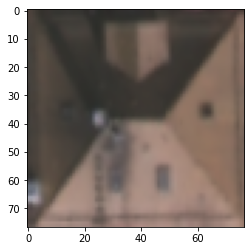

[2 0 0 2 0 0 1 1 0 2 0 2 0 0 0 0 0 0 0 2 2 2 1 0 2 1 0 1 1 1 2 2]


In [49]:
# A few random samples
use_samples = [300]
# Generate plots for samples
for sample in use_samples:
    # Generate a plot
    reshaped_image = train_generator[300]
    im = np.array(reshaped_image[0])#.reshape((-1,77,77,3)) 
    plt.imshow(im[8,:,:,:])
    plt.show()
predictions = reconstructed_model.predict(im)
#print(predictions)
classes_predict = np.argmax(predictions, axis = 1)
#print(classes[classes_predict[0]])
print(classes_predict)

In [3]:
# Now we need to do the next layers: recognition of rooftops
# Freeze the previous layer
base_model = keras.models.load_model('my_model')
base_model.trainable = False

In [123]:
# Get a ResNet50 model
def resnet50_model_top_layer(classes=3, *args, **kwargs):
    # Create an input layer 
    input = keras.layers.Input(shape=(None, None, 3))

    x = base_model(input, training=False)
    
    output = keras.layers.Dense((1000))(x)

    output = keras.layers.Dense(1000,activation='relu')(x)
    
    output = keras.layers.Activation('relu',  name='conv1_relu_1')(output)
    print(output.shape)
    #output = tf.keras.layers.Reshape([-1,9000])(output)
    output = keras.layers.Dense(10000,activation='relu')(output)
    # Create output layers
    #print(output.shape)
    output = keras.layers.BatchNormalization(axis=1, epsilon=1e-5, name='bn_conv1')(output)
    output = keras.layers.Activation('relu', name='conv1_relu')(output)
    
    output = tf.reshape(output, [1, output.shape[1], 1])
    print(output.shape)
    output = tf.keras.layers.AveragePooling1D(pool_size=2,strides=2, padding='valid',name='pooling')(output)
    print(output.shape)
    
    output = tf.keras.layers.Conv1D(2, 5, activation='relu', input_shape=output.shape,name='conv1d')(output)
    print(output.shape)
    #output = keras.layers.Dense(300000,activation='relu')(x)
    output = tf.keras.layers.Reshape([-1,output.shape[1],output.shape[2]])(output)
    print(output.shape)
    output = keras.layers.MaxPooling2D((3, 3), strides=(2, 2), padding='same', name='pool1')(output)
    print(output.shape)
    output = tf.keras.layers.Flatten()(output)
    print(output.shape)
    output = tf.keras.layers.Reshape([-1,output.shape[1]])(output)
    print(output.shape)
    #output = keras.layers.GlobalAveragePooling2D(name='pool5')(output)
    output = keras.layers.Dense(classes, activation='softmax', name='fc1000')(output)
    print('output',output.shape)
    # Create a model from input layer and output layers
    model = keras.models.Model(inputs=input, outputs=output, *args, **kwargs)
    # Print model
    #print()
    print(model.summary(), '\n')
    # Compile the model
    model.compile(loss='categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(lr=0.01, clipnorm=0.001), metrics=['accuracy'])
    # Return a model
    return model

In [124]:
model = resnet50_model_top_layer(3)

(None, 1000)
(1, 10000, 1)
(1, 5000, 1)
(1, 4996, 2)
(1, 1, 4996, 2)
(1, 1, 2498, 2)
(1, 4996)
(1, 1, 4996)
output (1, 1, 3)
Model: "model_27"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_54 (InputLayer)        [(None, None, None, 3)]   0         
_________________________________________________________________
model_3 (Model)              (None, 3)                 23593795  
_________________________________________________________________
dense_157 (Dense)            (None, 1000)              4000      
_________________________________________________________________
conv1_relu_1 (Activation)    (None, 1000)              0         
_________________________________________________________________
dense_158 (Dense)            (None, 10000)             10010000  
_________________________________________________________________
bn_conv1 (BatchNormalization (None, 10000)             40000     

In [118]:
# Variables, 25 epochs so far
epochs = 10
batch_size = 64

model.fit(train_generator, 
            steps_per_epoch=train_generator.samples // batch_size, 
            validation_data=validation_generator, 
            validation_steps=validation_generator.samples // batch_size,
            epochs=epochs)

# Save model to disk
#path = os.path.join(os.getcwd(),'resnet_50.h5')
model.save('Final_Model')
print('Saved model to disk!')
# Get labels
labels = train_generator.class_indices
# Invert labels
classes = {}
for key, value in labels.items():
    classes[value] = key.capitalize()
# Save classes to file
with open(os.path.join(os.getcwd(),'classes.pkl'), 'wb') as file:
    pickle.dump(classes, file)
print('Saved classes to disk!')

Epoch 1/10


InvalidArgumentError:  Can not squeeze dim[0], expected a dimension of 1, got 32
	 [[node model_25/bn_conv1/moments/Squeeze (defined at tmp/ipykernel_6177/510903563.py:9) ]] [Op:__inference_train_function_274265]

Function call stack:
train_function
